In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import glob
import nibabel as nib
from datetime import datetime
import random
import pdb

import medutils

import torch

import torch
from torch.nn import Linear
from torch.nn.functional import relu
from torch.nn.init import eye_

from vn_layers import *

BART toolbox not setup properly or not available


### Load Data and Images

In [2]:
csv_path_raw = '/Users/shizhehe/dev/research/vector_neurons_mri/vnn/data/other/ADNIMERGE.csv'  # label for each timepoint (CN, AD, Demantia, MCI, LMCI, EMCI)
data_path = '/Users/shizhehe/dev/research/vector_neurons_mri/vnn/data/other/'
df = pd.read_csv(csv_path_raw, usecols=['PTID', 'DX_bl', 'DX', 'EXAMDATE', 'AGE'])
#df = pd.read_csv(csv_path_raw)

img_paths = glob.glob(data_path + '*.nii.gz')
img_paths = sorted(img_paths)
img_paths

['/Users/shizhehe/dev/research/vector_neurons_mri/vnn/data/other/002_S_0295-2006-04-18_08_20_30.0.nii.gz']

In [3]:
df.head()

,PTID,EXAMDATE,DX_bl,AGE,DX
0,011_S_0002,2005-09-08,CN,74.3,CN
1,011_S_0003,2005-09-12,AD,81.3,Dementia
2,011_S_0003,2006-03-13,AD,81.3,Dementia
3,011_S_0003,2006-09-12,AD,81.3,Dementia
4,011_S_0003,2007-09-12,AD,81.3,Dementia


In [4]:
print("Loading {} image(s)".format(len(img_paths)))

for img_path in img_paths:
    img_nib = nib.load(os.path.join(img_path))
    img = img_nib.get_fdata()
    #img = (img - np.mean(img)) / np.std(img)
    #subj_img.create_dataset(os.path.basename(img_path), data=img)

Loading 1 image(s)


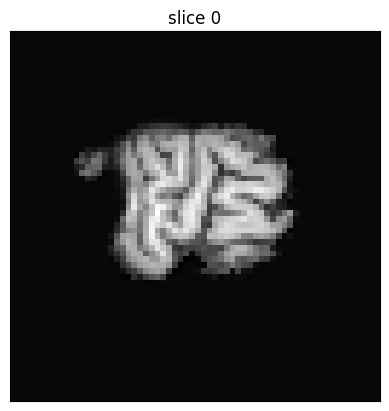

In [5]:
# ----- visualize volume -----
medutils.visualization.show(img[5])
#medutils.visualization.show(img)
#plt.show()

### Prove SO3-Equivariance of layers

Sanity check that pytorch linear layer is so3 equivariant, will be using that to check implementations of tranformation. Linear layer is by nature SO3-equivariant, if no bias term

In [34]:
def test_so3_equivariance(layer, name):
    # Define a rotation matrix
    rotation_matrix = torch.tensor([[1, 0, 0],
                                    [0, 0, -1],
                                    [0, 1, 0]], dtype=torch.float)

    # Define the input data
    input_data = torch.tensor([[1, 2, 3],
                               [4, 5, 6]], dtype=torch.float)

    # Define the linear layer
    linear_layer = layer
    #linear_layer = Linear(in_features=3, out_features=3, bias=False)
    # Initialize the weight matrix of the linear layer
    #eye_(linear_layer.weight)

    # Apply the rotation to both input and output data
    rotated_input = torch.matmul(input_data, rotation_matrix.T)
    
    rotated_output = layer(rotated_input)

    # Apply the rotation only to the input data and pass it through the linear layer
    output_after_rotation = torch.matmul(layer(input_data), rotation_matrix.T)

    # Compare the results
    if torch.allclose(rotated_output, output_after_rotation):
        print(f'{name} layer is SO3 equivariant.')
    else:
        print(f'{name} layer is NOT SO3 equivariant.')

# Test the SO3 equivariance of the linear layer
linear_layer = Linear(in_features=3, out_features=3, bias=False)
eye_(linear_layer.weight)
test_so3_equivariance(linear_layer, 'Linear')

Linear layer is SO3 equivariant.


Test VNN Layer SO3-Equivariance

In [9]:
# Test the SO3 equivariance of the VNNlinear layer
linear_layer = VNLinear(in_channels=3, out_channels=3)
eye_(linear_layer.map_to_feat.weight)
test_so3_equivariance(linear_layer, 'Linear')

tensor([[ 1., -3.,  2.],
        [ 4., -6.,  5.]])
Linear layer is SO3 equivariant.


In [12]:
class VNLeakyReLU(nn.Module):
    def __init__(self, in_channels, share_nonlinearity=False, negative_slope=0.2):
        super(VNLeakyReLU, self).__init__()
        if share_nonlinearity == True:
            self.map_to_dir = nn.Linear(in_channels, 1, bias=False)
        else:
            self.map_to_dir = nn.Linear(in_channels, in_channels, bias=False)
        self.negative_slope = negative_slope
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        d = self.map_to_dir(x.transpose(1,-1)).transpose(1,-1)
        dotprod = (x*d).sum(1, keepdim=True) # change to 1 depending on shape
        mask = (dotprod >= 0).float()
        d_norm_sq = (d*d).sum(1, keepdim=True) # change to 1 depending on shape
        x_out = self.negative_slope * x + (1-self.negative_slope) * (mask*x + (1-mask)*(x-(dotprod/(d_norm_sq+EPS))*d))
        return x_out

In [16]:
# Test the SO3 equivariance of LeakyReLU
linear_layer = VNLeakyReLU(in_channels=3)
eye_(linear_layer.map_to_dir.weight)
test_so3_equivariance(linear_layer, 'LeakyReLU')

LeakyReLU layer is SO3 equivariant.


In [32]:
class VNMaxPool(nn.Module):
    def __init__(self, in_channels):
        super(VNMaxPool, self).__init__()
        self.map_to_dir = nn.Linear(in_channels, in_channels, bias=False)
    
    def forward(self, x):
        '''
        x: point features of shape [B, N_feat, 3, N_samples, ...]
        '''
        d = self.map_to_dir(x.transpose(1,-1)).transpose(1,-1)
        dotprod = (x*d).sum(1, keepdims=True)
        idx = dotprod.max(dim=-1, keepdim=False)[1]
        index_tuple = torch.meshgrid([torch.arange(j) for j in x.size()[:-1]]) + (idx,)
        x_max = x[index_tuple]
        return x_max

In [35]:
# Test the SO3 equivariance of the VNMaxPool layer
max_pool = VNMaxPool(in_channels=3)
eye_(max_pool.map_to_dir.weight)
test_so3_equivariance(max_pool, 'Max Pooling')
# have to incorporate max pooling shape!!! can try with custom rotate function 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 3x3)

## Implementation of SO3 Transformations

Also write function to reverse, which is simply doing a rotation with the transpose of the rotation matrix

Try with 2D transformations first?

Implement rotation given a rotation matrix and image/volume to generate new image/volume

### Pytorch3D

In [8]:
img.shape

(64, 64, 64)

In [9]:
img_tensor = torch.from_numpy(img)
img_tensor.shape

torch.Size([64, 64, 64])

In [13]:
from pytorch3d.transforms import RotateAxisAngle, Rotate, random_rotations

x = torch.rand(64, 64, 3)
trot = RotateAxisAngle(angle=90, axis="Z", degrees=True)
x2 = trot.transform_points(x)
#emb2 ,feat = classifier(x2)
#inemb1 = trot.transform_points(emb)
#print (emb2-inemb1)
#print(emb2)

### SciPy

In [36]:
import numpy as np
from scipy.ndimage import rotate

# Assuming you have a 64x64x64 MRI volume stored in a numpy array called "volume"

# Specify the rotation angle in degrees
rotation_angle = 45

# Compute the rotation in radians
rotation_angle_rad = np.deg2rad(rotation_angle)

# Perform the rotation using the rotate function
rotated_volume = rotate(img, rotation_angle, axes=(0, 2), reshape=False)

# Note: The "axes" argument specifies the axes along which the rotation is performed.
# In this example, we are rotating along the first and second axes (axes 0 and 1),
# which correspond to the X and Y dimensions of the volume, respectively.

# The resulting rotated_volume will be a new numpy array with the rotated MRI volume.

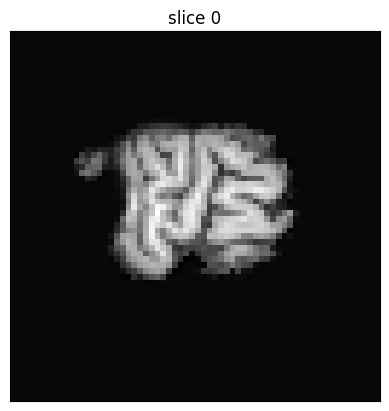

In [110]:
medutils.visualization.show(img[5])

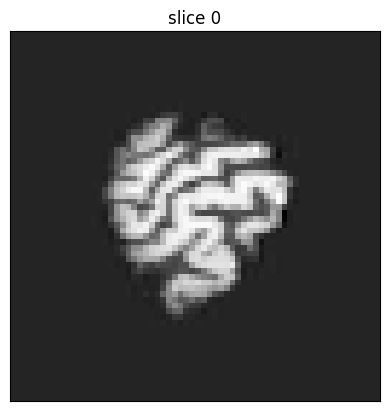

In [111]:
# ----- visualize volume -----
medutils.visualization.show(rotated_volume[5])
#medutils.visualization.show(img)
#plt.show()

In [37]:
# Specify the rotation angle in degrees
rotation_angle = 90
# Compute the rotation in radians
rotation_angle_rad = np.deg2rad(rotation_angle)

rotation_axes = (0, 1)


linear_layer = Linear(in_features=3, out_features=3, bias=False)

# Define the input data
input_data = torch.tensor([[1, 2, 3],
                            [4, 5, 6]], dtype=torch.float)

# Define the linear layer
#linear_layer = Linear(in_features=3, out_features=3, bias=False)
# Initialize the weight matrix of the linear layer
eye_(linear_layer.weight)

# Apply the rotation to both input and output data
rotated_input = rotate(input_data, rotation_angle, axes=rotation_axes, reshape=False)
rotated_input = torch.from_numpy(rotated_input)

rotated_output = linear_layer(rotated_input)

# Apply the rotation only to the input data and pass it through the linear layer
output = linear_layer(input_data).detach().numpy()

output_after_rotation = rotate(output, rotation_angle, axes=rotation_axes, reshape=False)
output_after_rotation = torch.from_numpy(output_after_rotation)

# Compare the results
if torch.allclose(rotated_output, output_after_rotation):
    print("Transformations perserve SO3 equivariance!")
else:
    print("Transformations do not perserve SO3 equivariance!!!")

Transformations perserve SO3 equivariance!


In [38]:
# Specify the rotation angle in degrees
rotation_angle = 90
# Compute the rotation in radians
rotation_angle_rad = np.deg2rad(rotation_angle)

rotation_axes = (0, 1)


linear_layer = Linear(in_features=3, out_features=3, bias=False)

# Define the input data
input_data = torch.tensor([[1, 2, 3]], dtype=torch.float)

# Define the linear layer
#linear_layer = Linear(in_features=3, out_features=3, bias=False)
# Initialize the weight matrix of the linear layer
eye_(linear_layer.weight)

# Apply the rotation to both input and output data
rotated_input = rotate(input_data, rotation_angle, axes=rotation_axes, reshape=False)
rotated_input = torch.from_numpy(rotated_input)

rotated_output = linear_layer(rotated_input)

# Apply the rotation only to the input data and pass it through the linear layer
output = linear_layer(input_data).detach().numpy()

output_after_rotation = rotate(output, rotation_angle, axes=rotation_axes, reshape=False)
output_after_rotation = torch.from_numpy(output_after_rotation)

# Compare the results
if torch.allclose(rotated_output, output_after_rotation):
    print("Transformations perserve SO3 equivariance!")
else:
    print("Transformations do not perserve SO3 equivariance!!!")

Transformations perserve SO3 equivariance!


Test with actual MRI volume and different input/output sizes

In [39]:
# Specify the rotation angle in degrees
rotation_angle = 90
# Compute the rotation in radians
rotation_angle_rad = np.deg2rad(rotation_angle)

rotation_axes = (0, 1)

input_img = torch.tensor(img, dtype=torch.float)
#input_img = img

# Define the linear layer
linear_layer = Linear(in_features=64, out_features=4, bias=False)
# Initialize the weight matrix of the linear layer
eye_(linear_layer.weight)

# Apply the rotation to both input and output data
rotated_input = rotate(input_img, rotation_angle, axes=rotation_axes, reshape=False)
rotated_input = torch.tensor(rotated_input, dtype=torch.float)

rotated_output = linear_layer(rotated_input)

# Apply the rotation only to the input data and pass it through the linear layer
output = linear_layer(input_img).detach().numpy()

output_after_rotation = rotate(output, rotation_angle, axes=rotation_axes, reshape=False)
output_after_rotation = torch.from_numpy(output_after_rotation)

# Compare the results
if torch.allclose(rotated_output, output_after_rotation):
    print("Transformations perserve SO3 equivariance!")
else:
    print("Transformations do not perserve SO3 equivariance!!!")

Transformations perserve SO3 equivariance!


In [39]:
rotated_input.shape

torch.Size([64, 64, 64])

In [40]:
output.shape

(64, 64, 4)

issue with using the scipy rotate fucntion directly, no control over selection of rotation matrix!

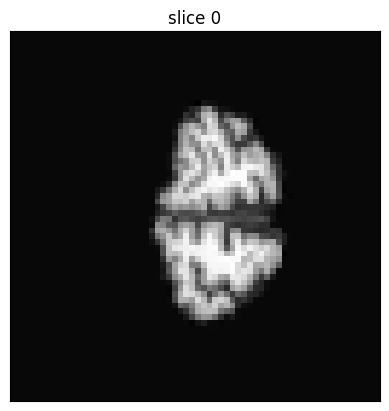

In [41]:
# ----- visualize volume -----
medutils.visualization.show(rotated_input[5])
#medutils.visualization.show(img)
#plt.show()

### Rotation as in PyTorch Data Augmentations

In [56]:
...

Ellipsis

In [ ]:
rotation_axes = (0, 1)

# Define the input data
input_data = torch.tensor([[1, 2, 3],
                            [4, 5, 6]], dtype=torch.float)

# Define the linear layer
linear_layer = Linear(in_features=3, out_features=3, bias=False)
# Initialize the weight matrix of the linear layer
eye_(linear_layer.weight)

# Apply the rotation to both input and output data
...

rotated_output = linear_layer(rotated_input)

# Apply the rotation only to the input data and pass it through the linear layer
output = linear_layer(input_data).detach().numpy()

...
output_after_rotation = torch.from_numpy(output_after_rotation)

# Compare the results
if torch.allclose(rotated_output, output_after_rotation):
    print("Transformations perserve SO3 equivariance!")
else:
    print("Transformations do not perserve SO3 equivariance!!!")

### Custom implementation of SciPy

In [7]:
from scipy import special
from scipy.ndimage import affine_transform
import itertools

from scipy.ndimage import _ni_support


def generate_rotation_matrix(angle):
    c, s = special.cosdg(angle), special.sindg(angle)
    return np.array([[c, s], [-s, c]])


def rotate_custom(input, rot_matrix, axes=(1, 0), reshape=True, output=None, order=3,
           mode='constant', cval=0.0, prefilter=True, verbose=False):
    input_arr = np.asarray(input)
    ndim = input_arr.ndim
    axes = list(axes)

    # some safe checks
    if ndim < 2:
        print('Danger! input array should be at least 2D')
        input_arr = np.expand_dims(input_arr, axis=0)
    if len(axes) != 2:
        raise ValueError('axes should contain exactly two values')
    if not all([float(ax).is_integer() for ax in axes]):
        raise ValueError('axes should contain only integer values')
    
    # safe guard for negative axes for reverse indexing
    if axes[0] < 0:
        axes[0] += ndim
    if axes[1] < 0:
        axes[1] += ndim
    if axes[0] < 0 or axes[1] < 0 or axes[0] >= ndim or axes[1] >= ndim:
        raise ValueError('invalid rotation plane specified')
    axes.sort()


    img_shape = np.asarray(input_arr.shape)
    in_plane_shape = img_shape[axes]


    if reshape:
        # Compute transformed input bounds
        iy, ix = in_plane_shape
        out_bounds = rot_matrix @ [[0, 0, iy, iy],
                                   [0, ix, 0, ix]]
        # Compute the shape of the transformed input plane
        out_plane_shape = (out_bounds.ptp(axis=1) + 0.5).astype(int)
    else:
        out_plane_shape = img_shape[axes]


    out_center = rot_matrix @ ((out_plane_shape - 1) / 2)
    in_center = (in_plane_shape - 1) / 2
    offset = in_center - out_center

    output_shape = img_shape
    output_shape[axes] = out_plane_shape
    output_shape = tuple(output_shape)

    output = np.zeros(output_shape, dtype=input_arr.dtype.name)
    #complex_output = np.iscomplexobj(input_arr)
    #output = _ni_support._get_output(output, input_arr, shape=output_shape,
    #                                 complex_output=complex_output)

    if ndim == 2:
        affine_transform(input_arr, rot_matrix, offset, output_shape, output,
                         order, mode, cval, prefilter)
    else:
        # If ndim > 2, the rotation is applied over all the planes
        # parallel to axes
        planes_coord = itertools.product(
            *[[slice(None)] if ax in axes else range(img_shape[ax])
              for ax in range(ndim)])
        

        out_plane_shape = tuple(out_plane_shape)

        for coordinates in planes_coord:
            #print(coordinates)
            
            ia = input_arr[coordinates]
            oa = output[coordinates]

            affine_transform(ia, rot_matrix, offset, out_plane_shape,
                             oa, order, mode, cval, prefilter)

            #print(oa)

    return output

In [41]:
def rotate_custom_angle(input, angle, axes=(1, 0), reshape=True, output=None, order=3,
           mode='constant', cval=0.0, prefilter=True, verbose=False):
    input_arr = np.asarray(input)
    ndim = input_arr.ndim

    if ndim < 2:
        raise ValueError('input array should be at least 2D')

    axes = list(axes)

    if len(axes) != 2:
        raise ValueError('axes should contain exactly two values')

    if not all([float(ax).is_integer() for ax in axes]):
        raise ValueError('axes should contain only integer values')

    if axes[0] < 0:
        axes[0] += ndim
    if axes[1] < 0:
        axes[1] += ndim
    if axes[0] < 0 or axes[1] < 0 or axes[0] >= ndim or axes[1] >= ndim:
        raise ValueError('invalid rotation plane specified')

    axes.sort()

    c, s = special.cosdg(angle), special.sindg(angle)

    rot_matrix = np.array([[c, s],
                              [-s, c]])

    img_shape = np.asarray(input_arr.shape)
    in_plane_shape = img_shape[axes]
    if reshape:
        # Compute transformed input bounds
        iy, ix = in_plane_shape
        out_bounds = rot_matrix @ [[0, 0, iy, iy],
                                   [0, ix, 0, ix]]
        # Compute the shape of the transformed input plane
        out_plane_shape = (out_bounds.ptp(axis=1) + 0.5).astype(int)
    else:
        out_plane_shape = img_shape[axes]

    out_center = rot_matrix @ ((out_plane_shape - 1) / 2)
    in_center = (in_plane_shape - 1) / 2
    offset = in_center - out_center

    output_shape = img_shape
    output_shape[axes] = out_plane_shape
    output_shape = tuple(output_shape)

    complex_output = np.iscomplexobj(input_arr)
    output = _ni_support._get_output(output, input_arr, shape=output_shape,
                                     complex_output=complex_output)

    if ndim <= 2:
        affine_transform(input_arr, rot_matrix, offset, output_shape, output,
                         order, mode, cval, prefilter)
    else:
        # If ndim > 2, the rotation is applied over all the planes
        # parallel to axes
        planes_coord = itertools.product(
            *[[slice(None)] if ax in axes else range(img_shape[ax])
              for ax in range(ndim)])

        out_plane_shape = tuple(out_plane_shape)

        for coordinates in planes_coord:
            ia = input_arr[coordinates]
            oa = output[coordinates]
            affine_transform(ia, rot_matrix, offset, out_plane_shape,
                             oa, order, mode, cval, prefilter)

    return output


In [14]:
# Specify the rotation angle in degrees
rotation_angle = 90
# Compute the rotation in radians
rotation_angle_rad = np.deg2rad(rotation_angle)
rotation_matrix = generate_rotation_matrix(rotation_angle)

rotation_axes = (0, 1)


linear_layer = Linear(in_features=3, out_features=3, bias=False)

# Define the input data
input_data = torch.tensor([[1, 2, 3],
                            [4, 5, 6]], dtype=torch.float)

# Define the linear layer
#linear_layer = Linear(in_features=3, out_features=3, bias=False)
# Initialize the weight matrix of the linear layer
eye_(linear_layer.weight)

# Apply the rotation to both input and output data
rotated_input = rotate_custom(input_data, rotation_matrix, axes=rotation_axes, reshape=False)
rotated_input = torch.from_numpy(rotated_input)

rotated_output = linear_layer(rotated_input)

# Apply the rotation only to the input data and pass it through the linear layer
output = linear_layer(input_data).detach().numpy()

output_after_rotation = rotate_custom(output, rotation_matrix, axes=rotation_axes, reshape=False)
output_after_rotation = torch.from_numpy(output_after_rotation)

# Compare the results
if torch.allclose(rotated_output, output_after_rotation):
    print("Transformations perserve SO3 equivariance!")
else:
    print("Transformations do not perserve SO3 equivariance!!!")

Transformations perserve SO3 equivariance!


In [20]:
# Specify the rotation angle in degrees
rotation_angle = 90
# Compute the rotation in radians
rotation_angle_rad = np.deg2rad(rotation_angle)
rotation_matrix = generate_rotation_matrix(rotation_angle)

rotation_axes = (0, 1)

input_img = torch.tensor(img, dtype=torch.float)
#input_img = img

# Define the linear layer
linear_layer = Linear(in_features=64, out_features=64, bias=False)
# Initialize the weight matrix of the linear layer
eye_(linear_layer.weight)

# Apply the rotation to both input and output data
rotated_input = rotate_custom(input_img, rotation_matrix, axes=rotation_axes, reshape=False)
rotated_input = torch.tensor(rotated_input, dtype=torch.float)

rotated_output = linear_layer(rotated_input)

# Apply the rotation only to the input data and pass it through the linear layer
output = linear_layer(input_img).detach().numpy()

output_after_rotation = rotate_custom(output, rotation_matrix, axes=rotation_axes, reshape=False)
output_after_rotation = torch.from_numpy(output_after_rotation)

# Compare the results
if torch.allclose(rotated_output, output_after_rotation):
    print("Transformations perserve SO3 equivariance!")
else:
    print("Transformations do not perserve SO3 equivariance!!!")

Transformations perserve SO3 equivariance!


In [18]:
# Specify the rotation angle in degrees
rotation_angle = 90
# Compute the rotation in radians
rotation_angle_rad = np.deg2rad(rotation_angle)
rotation_matrix = generate_rotation_matrix(rotation_angle)

rotation_axes = (0, 1)

input_img = torch.tensor(img, dtype=torch.float)
#input_img = img

# Define the linear layer
linear_layer = Linear(in_features=64, out_features=3, bias=False)
# Initialize the weight matrix of the linear layer
eye_(linear_layer.weight)

# Apply the rotation to both input and output data
rotated_input = rotate_custom(input_img, rotation_matrix, axes=rotation_axes, reshape=False)
rotated_input = torch.tensor(rotated_input, dtype=torch.float)

rotated_output = linear_layer(rotated_input)

# Apply the rotation only to the input data and pass it through the linear layer
output = linear_layer(input_img).detach().numpy()

output_after_rotation = rotate_custom(output, rotation_matrix, axes=rotation_axes, reshape=False)
output_after_rotation = torch.from_numpy(output_after_rotation)

# Compare the results
if torch.allclose(rotated_output, output_after_rotation):
    print("Transformations perserve SO3 equivariance!")
else:
    print("Transformations do not perserve SO3 equivariance!!!")

Transformations perserve SO3 equivariance!


Input should be rotated by 90 degrees


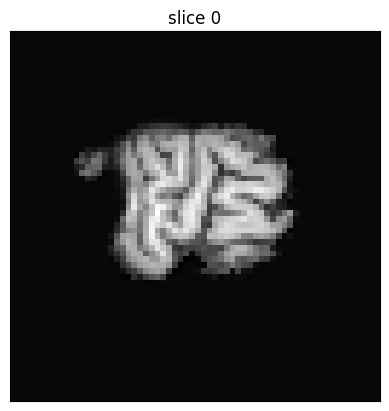

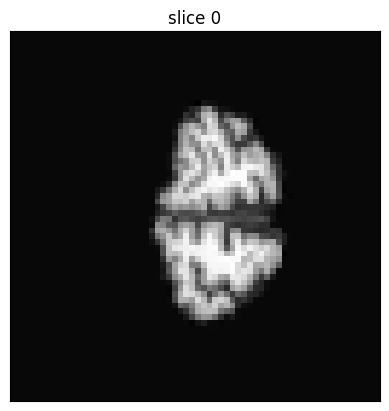

In [19]:
# ----- visualize volume -----
medutils.visualization.show(input_img.numpy()[5])
print(f'Input should be rotated by {rotation_angle} degrees')
medutils.visualization.show(rotated_input.detach().numpy()[5])

Test inverting rotations with matrix transposes

-> inverts correctly if in 90 degrees steps, or else filler; visually fine

In [47]:
# Specify the rotation angle in degrees
rotation_angle = 45

rotation_axes = (1, 2)

input_img = torch.tensor(img, dtype=torch.float)

# Apply the rotation to input data
rotated_input = rotate_custom_angle(input_img, 45, axes=rotation_axes, reshape=False)
rotated_input = torch.tensor(rotated_input, dtype=torch.float)

# Invert transformation
inverted = rotate_custom_angle(rotated_input, 360-45, axes=rotation_axes, reshape=False)
inverted = torch.tensor(inverted, dtype=torch.float)

# Compare the results
if torch.allclose(input_img, inverted):
    print("Transformations are inverted correctly!")
else:
    print("Transformations are not inverted correctly!!!")

diff = input_img - inverted
print(f'Pixel-wise sum of difference between input and inverted: {diff.sum()}')

Transformations are not inverted correctly!!!
Pixel-wise sum of difference between input and inverted: 175616.03125


In [45]:
# Specify the rotation angle in degrees
rotation_angle = 45
# Compute the rotation in radians
rotation_angle_rad = np.deg2rad(rotation_angle)
rotation_matrix = generate_rotation_matrix(rotation_angle)

rotation_axes = (1, 2)

input_img = torch.tensor(img, dtype=torch.float)

# Apply the rotation to input data
rotated_input = rotate_custom(input_img, rotation_matrix, axes=rotation_axes, reshape=False)
rotated_input = torch.tensor(rotated_input, dtype=torch.float)

# Invert transformation
inverted = rotate_custom(rotated_input, rotation_matrix.T, axes=rotation_axes, reshape=False)
inverted = torch.tensor(inverted, dtype=torch.float)

# Compare the results
if torch.allclose(input_img, inverted):
    print("Transformations are inverted correctly!")
else:
    print("Transformations are not inverted correctly!!!")

diff = input_img - inverted
print(f'Pixel-wise sum of difference between input and inverted: {diff.sum()}')

Transformations are not inverted correctly!!!
Pixel-wise sum of difference between input and inverted: 175616.03125


In [50]:
def normalize(img, vmin=None, vmax=None, max_int=255.0):
    """ normalize (magnitude) image
    :param image: input image (np.array)
    :param vmin: minimum input intensity value
    :param vmax: maximum input intensity value
    :param max_int: maximum output intensity value
    :return: normalized image
    """
    if np.iscomplexobj(img):
        # print('img is complex! Take absolute value.')
        img = np.abs(img.copy())
    if vmin == None:
        vmin = np.min(img)
    if vmax == None:
        vmax = np.max(img)
    img = (img - vmin)*(max_int)/(vmax - vmin)
    img = np.minimum(max_int, np.maximum(0.0, img))
    return img

In [54]:
t1 = normalize(input_img.detach().numpy())
t2 = normalize(inverted.detach().numpy())
diff_normalized = t1 - t2
print(f'Pixel-wise sum of difference between input and inverted after normalization: {diff_normalized.sum()}')

Pixel-wise sum of difference between input and inverted after normalization: -1968342.875


Input should be rotated by 45 degrees


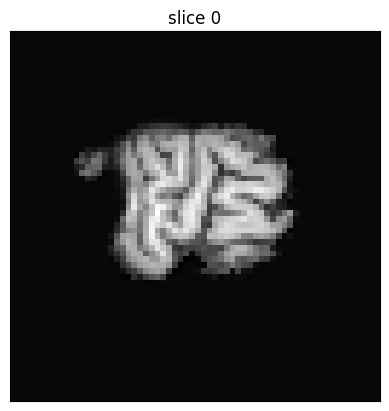

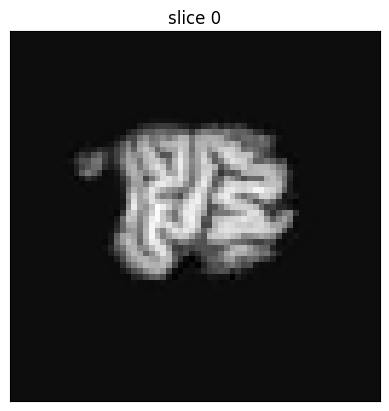

In [52]:
# ----- visualize volume -----
medutils.visualization.show(t1[5])
print(f'Input should be rotated by {rotation_angle} degrees')
medutils.visualization.show(t2[5])

visually ok, since scaled down in show function

Input should be rotated by 45 degrees


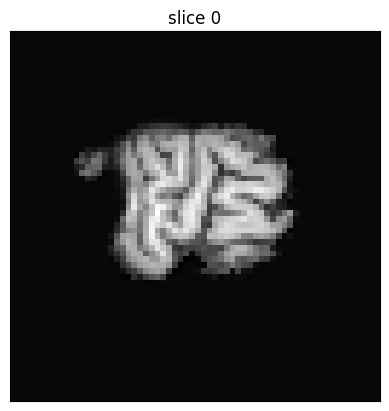

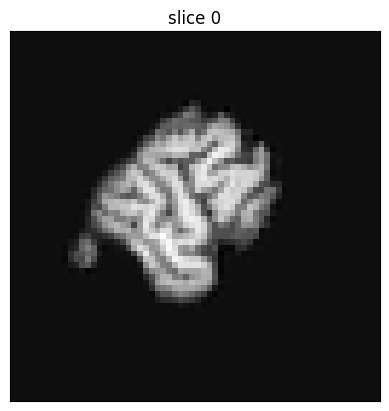

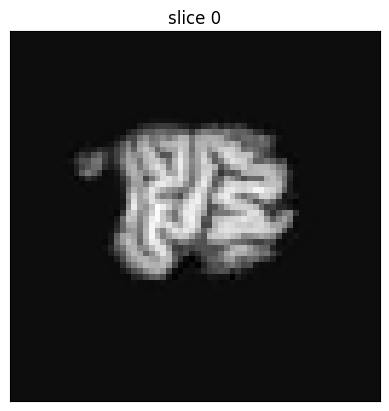

In [49]:
# ----- visualize volume -----
medutils.visualization.show(input_img.numpy()[5])
print(f'Input should be rotated by {rotation_angle} degrees')
medutils.visualization.show(rotated_input.detach().numpy()[5])
medutils.visualization.show(inverted.detach().numpy()[5])